## インポート

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(1234)

## データの読み込み

In [29]:
df = pd.read_csv('chap08/input/data-salary-2.txt')
df.head()

,X,Y,KID
0,7,457,1
1,10,482,1
2,16,518,1
3,25,535,1
4,5,427,1


## サンプルデータの散布図行列

In [4]:
class Dispatcher(object):
    
    def __init__(self, fontsize=20, alpha=0.6, cmap='RdBu', threshold=5):
        self.fontsize = fontsize
        self.alpha = alpha
        self.cmap = plt.get_cmap(cmap)
 
        # 離散値 / 連続値とみなす閾値
        self.threshold = threshold
        
    def comb(self, x_series, y_series, label=None, color=None):
        """ 下三角部分のプロット """       

        x_nunique = x_series.nunique()
        y_nunique = y_series.nunique()

        if x_nunique < self.threshold and y_nunique < self.threshold:
            # 離散値 x 離散値のプロット
            return self._dd_plot(x_series, y_series, label=label, color=color)
        
        elif x_nunique < self.threshold or y_nunique < self.threshold:
            # 離散値 x 連続値のプロット
             return self._dc_plot(x_series, y_series, label=label, color=color)
            
        else:
            # 連続値 x 連続値のプロット
            return plt.scatter(x_series, y_series, label=label, color=color)

    def _dd_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 離散値のプロット """

        # x, y 各組み合わせの個数を集計
        total = y_series.groupby([x_series, y_series]).count()

        # x, y軸をプロットする位置を取得
        xloc = total.index.labels[0] 
        yloc = total.index.labels[1] 
        values = total.values

        ax = plt.gca()
        for xp, yp, vp in zip(xloc, yloc, values):
            ax.annotate(vp, (xp, yp), fontsize=self.fontsize,
                        ha='center', va='center')

        # 組み合わせの個数を散布図としてプロット
        size = values / (values.max() * 1.1) * 100 * 20
        ax.scatter(xloc, yloc, s=size, label=label, color=color)
        ax.set_ylim(yloc[0] - 0.5, yloc[-1] + 0.5)
        
    def _dc_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 連続値のプロット """

        if y_series.nunique() < x_series.nunique():
            # y軸が離散値の場合は、x, yを入替
            # 水平方向に箱ひげ図をプロット
            x_series, y_series = y_series, x_series
            vert = False
        else:
            vert = True

        xlab, xun = pd.factorize(x_series)

        # 箱ひげ図用のデータの準備
        data = []
        for i, g in y_series.groupby(xlab):
            data.append(g) 
            
        ax = plt.gca()
        ax.boxplot(data, positions=np.arange(len(data)), vert=vert)

        # 散布図をプロット
        xloc = xlab + np.random.normal(scale=0.05, size=len(xlab))
        if not vert:
            y_series, xloc = xloc, y_series

        ax.scatter(xloc, y_series, label=label, color=color,
                   alpha=self.alpha)
   
    def diag(self, series, label=None, color=None):
        """ 対角部分のプロット """

        ax = series.plot.hist()
        ax = series.plot.kde(grid=False, ax=ax.twinx())
        ax.yaxis.set_visible(False)

    def ellipse(self, x_series, y_series, label=None, color=None):
        """ 上三角部分のプロット """        

        from matplotlib.patches import Ellipse
        
        # 相関係数を楕円としてプロット
        r = x_series.corr(y_series)
        c = self.cmap(0.5 * (r + 1))

        ax = plt.gca()
        ax.axis('off')
        ax.add_artist(Ellipse(xy=[.5, .5], width=np.sqrt(1 + r), height=np.sqrt(1 - r),
                              angle=45, facecolor=c, edgecolor='none', transform=ax.transAxes))
        ax.text(.5, .5, '{:.0f}'.format(r * 100), fontsize=self.fontsize,
                ha='center', va='center', transform=ax.transAxes)

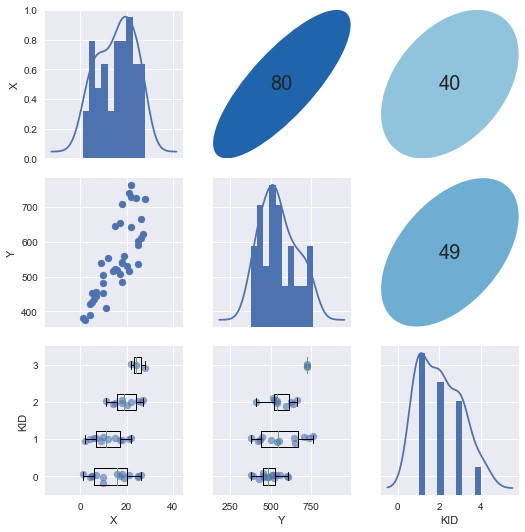

In [30]:
g = sns.PairGrid(df, diag_sharey=False)

d = Dispatcher()
# 対角成分
g.map_diag(d.diag)
# 下三角成分
g.map_lower(d.comb);
# 上三角成分
g.map_upper(d.ellipse);

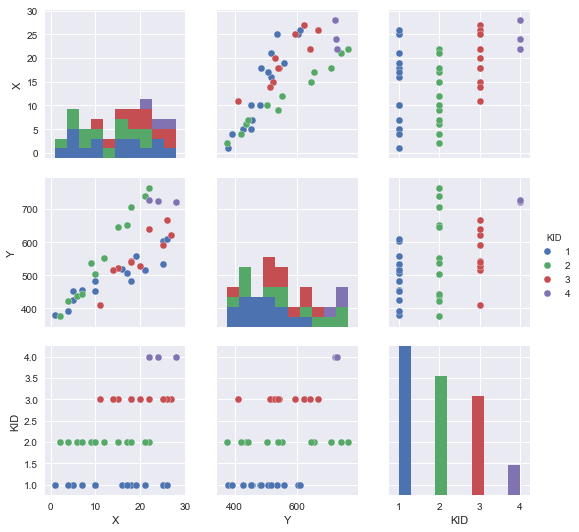

In [31]:
sns.pairplot(data=df, hue='KID')

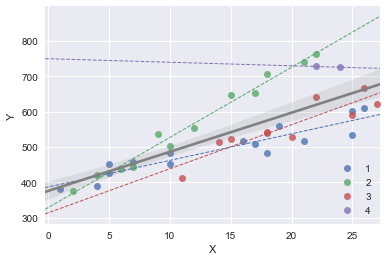

In [56]:
plt.figure()
for KID, df_sub, in df.groupby(by="KID"):
    sns.regplot(x=df_sub.X, y=df_sub.Y, label=KID, 
                ci=0, line_kws={"linestyle":"--", "linewidth":1.0})
sns.regplot(x=df.X, y=df.Y, scatter=False, ci=95, line_kws={"color":"gray"})
plt.legend()
plt.show()

## グループ差を考えない場合

$Y[n]$ ~ $ Normal( a + b X[n], \sigma )$

In [104]:
model_code="""
data {
  int N;
  real<lower=0> X[N];
  real<lower=0> Y[N];
}
parameters {
  real a;
  real b;
  real<lower=0> sigma;
}
model {
  for (n in 1:N)
    Y[n] ~ normal(a+b*X[n], sigma);
}
"""

from pystan import StanModel
data = dict(N=df.shape[0], X=df.X, Y=df.Y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_61362dfb074914604c7afc054dc80b14 NOW.


Inference for Stan model: anon_model_61362dfb074914604c7afc054dc80b14.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     375.86    0.58  24.68 325.57 359.51 375.71 392.75 423.73   1808    1.0
b      11.06    0.03   1.43   8.24  10.11  11.07  12.02  13.93   1676    1.0
sigma  68.45    0.18   8.08  54.73  62.88  67.72  73.26  86.28   2055    1.0
lp__  -184.1    0.03   1.28 -187.3 -184.7 -183.7 -183.1 -182.6   1435    1.0

Samples were drawn using NUTS at Fri May  4 00:33:35 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

## グループごとに切片と傾きを持つ場合

$Y[n]$ ~ $ Normal( a[KID[n]] + b[KID[n]] X[n], \sigma )$

In [105]:
model_code="""
data {
  int N;
  int K;
  real<lower=0> X[N];
  real<lower=0> Y[N];
  int<lower=1,upper=K> KID[N];
}
parameters {
  real a[K];
  real b[K];
  real<lower=0> sigma;
}
model {
  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]]+b[KID[n]]*X[n], sigma);
}
"""

from pystan import StanModel
data = dict(N=df.shape[0], K=df.KID.nunique(), X=df.X, KID=df.KID, Y=df.Y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_665e81ec62636dce2a56ebfc8f1cc926 NOW.


Inference for Stan model: anon_model_665e81ec62636dce2a56ebfc8f1cc926.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[0]  386.76    0.26  13.58 359.75 377.82 386.84 395.92 412.93   2771    1.0
a[1]  328.84    0.35  17.21 294.66 317.46  328.7 340.44 362.41   2414    1.0
a[2]  314.17    0.74  36.14 245.65  289.3 313.91 338.23  385.2   2371    1.0
a[3]  748.52    3.11 157.13 443.37  645.8 746.37 852.07 1065.2   2558    1.0
b[0]    7.53    0.02   0.84   5.91   6.98   7.51   8.09   9.26   2735    1.0
b[1]   19.84    0.03   1.26  17.42  18.99  19.86  20.69   22.3   2458    1.0
b[2]   12.44    0.04   1.78   8.89  11.24  12.45  13.66  15.87   2412    1.0
b[3]   -0.94    0.13   6.33 -13.55  -5.15   -0.9   3.21  11.37   2558    1.0
sigma  27.19    0.07   3.48  21.41  24.75  26.84  29.16  35.22   2291    1.0
lp__  -148.0    0.07   2.42 -153.7 -149.4

C:\Users\eX\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


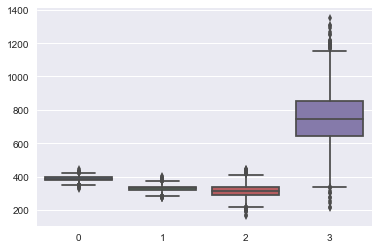

In [106]:
sns.boxplot(data=fit.extract()['a'])

## 階層モデル

$a[k]$ ~ $ Normal(a_{avg}, \sigma_a)$

$b[k]$ ~ $ Normal(b_{avg}, \sigma_b)$

$Y[n]$ ~ $ Normal( a[KID[n]] + b[KID[n]] X[n], \sigma )$

$k = 1, ..., K$

$n = 1, ..., N$

## シミュレーション

In [76]:
np.random.seed(123)
N =  40
K = 4
N_k = [15,12,10,3]
a0=350
b0=12
s_a=60
s_b=4
s_Y=25
X = np.random.randint(0, 35, size=N)
KID = np.repeat([0,1,2,3], N_k)

a = np.random.normal(size=K, loc=a0, scale=s_a)
b = np.random.normal(size=K, loc=b0, scale=s_b)

df_sim = pd.DataFrame({'X':X, 'KID':KID, 'a':a[KID], 'b':b[KID]})
#df_sim['a'] = a[df_sim.KID]
df_sim['Y_sim'] = np.random.normal(loc=df_sim.a + df_sim.b * df_sim.X, scale=s_Y)
df_sim

,KID,X,a,b,Y_sim
0,0,2,308.241129,10.621433,326.661362
1,0,28,308.241129,10.621433,564.123866
2,0,34,308.241129,10.621433,669.708323
3,0,17,308.241129,10.621433,497.239848
4,0,19,308.241129,10.621433,486.882787
5,0,22,308.241129,10.621433,548.806346
6,0,33,308.241129,10.621433,668.019735
7,0,32,308.241129,10.621433,677.484672
8,0,9,308.241129,10.621433,353.026717
9,0,32,308.241129,10.621433,662.689700


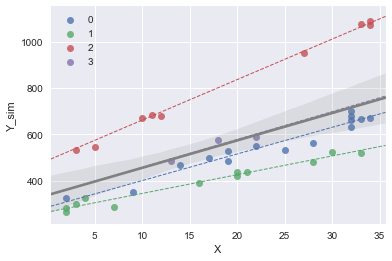

In [79]:
plt.figure()
for KID, df_sub, in df_sim.groupby(by="KID"):
    sns.regplot(x=df_sub.X, y=df_sub.Y_sim, label=KID, 
                ci=0, line_kws={"linestyle":"--", "linewidth":1.0})
sns.regplot(x=df_sim.X, y=df_sim.Y_sim, scatter=False, ci=95, line_kws={"color":"gray"})
plt.legend()
plt.show()

In [86]:
model_code="""
data {
  int N;
  int K;
  real<lower=0> X[N];
  real<lower=0> Y[N];
  int<lower=1,upper=K> KID[N];
}
parameters {
  real a0;
  real b0;
  real a[K];
  real b[K];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_y;
}
model {
  for (k in 1:K) {
    a[k] ~ normal(a0, s_a);
    b[k] ~ normal(b0, s_b);  
  }

  for (n in 1:N)
    Y[n] ~ normal(a[KID[n]]+b[KID[n]]*X[n], s_y);
}
"""

from pystan import StanModel
data = dict(N=df.shape[0], K=df.KID.nunique(), X=df.X, KID=df.KID, Y=df.Y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)
fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2b6cc21669ebc0749dd208adf369b9d7 NOW.


Inference for Stan model: anon_model_2b6cc21669ebc0749dd208adf369b9d7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0   389.76    4.02 138.14 186.67 337.29 370.34 420.57 680.73   1182    1.0
b0    11.91    0.41   9.01  -6.03   9.33  12.43  15.13  26.99    489   1.01
a[0]  384.2    0.36  15.08  354.2 374.54 384.33 394.04 414.21   1744    1.0
a[1] 334.13    0.36  17.34 300.09  322.4 333.89 345.98 368.27   2268    1.0
a[2]  322.5    0.78   32.7 256.27 301.47 322.66 344.46 383.98   1742    1.0
a[3] 491.09     4.6 139.16  302.0 383.15 461.22 573.55 825.44    915    1.0
b[0]   7.69    0.02   0.92   5.86   7.08   7.67   8.29   9.52   1850    1.0
b[1]  19.44    0.03   1.28  16.89  18.58  19.47   20.3  21.94   2306    1.0
b[2]  12.04    0.04   1.63   8.92  10.94  12.01  13.12  15.37   1725    1.0
b[3]    9.4    0.19   5.61  -3.87   6.02  10.55  13

C:\Users\eX\Anaconda3\lib\site-packages\seaborn\categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


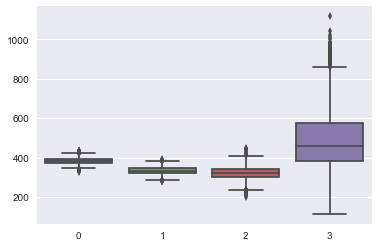

In [103]:
sns.boxplot(data=fit.extract()['a'])